In [4]:
%pylab inline
%load_ext autoreload
%autoreload 2

#%aimport deepsvr

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from analysis_utils.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot
from analysis_utils.Analysis import print_accuracy_and_classification_report, predict_classes, get_somatic_error_type

sns.set_style("white")
sns.set_context('poster')

In [7]:
# Pull in training data
training_data = pd.read_pickle('data/training_data_preprocessed.pkl')
training_data.sort_index(axis=1, inplace=True)

In [8]:
training_data.head()

,call,disease_AML,disease_GST,disease_MPNST,disease_SCLC,disease_breast,disease_colorectal,disease_glioblastoma,disease_lymphoma,disease_melanoma,...,tumor_var_avg_distance_to_q2_start_in_q2_reads,tumor_var_avg_mapping_quality,tumor_var_avg_num_mismaches_as_fraction,tumor_var_avg_pos_as_fraction,tumor_var_avg_se_mapping_quality,tumor_var_avg_sum_mismatch_qualities,tumor_var_count,tumor_var_num_minus_strand,tumor_var_num_plus_strand,tumor_var_num_q2_containing_reads
fSsFJH1EY3AKAWF2 BER9Q2JBY3EPAWUcZUpOaAZCc0MRSRU=,a,1,0,0,0,0,0,0,0,0,...,0.377551,0.192667,0.057692,0.62,0.140667,0.215676,0.000990,0.001075,0.000806,0.000735
fSsFJH1EY3AKAWF2 BEV9RGJDY3UABGEcYkpMaAJNdkcXSQY=,s,1,0,0,0,0,0,0,0,0,...,0.479592,1.000000,0.019231,0.51,0.614833,0.074597,0.007054,0.006450,0.007258,0.006860
fSsFJH1EY3AKAWF2 BEV9RGJDZ3oMAWMcYkpMbA1Bc0UTSQY=,s,1,0,0,0,0,0,0,0,0,...,0.408163,1.000000,0.019231,0.53,0.616667,0.078946,0.003898,0.004192,0.003226,0.003553
fSsFJH1EY3AKAWF2 BEV9QmFCZXsLA2IcZElNbgxGcUN9SQY=,a,1,0,0,0,0,0,0,0,0,...,0.479592,0.483333,0.346154,0.96,0.483333,0.661405,0.000124,0.000000,0.000269,0.000245
fSsFJH1EY3AKAWF2 BEZ9RmNHanUOA2YBfElLaQ1DcEFnRwZ8eg==,a,1,0,0,0,0,0,0,0,0,...,0.122449,0.270000,0.096154,0.28,0.200000,0.302414,0.001547,0.001397,0.001613,0.001593


In [9]:
# Remove AML31 case
aml31_training = training_data[training_data.index.str.contains('fSsMNn1DZ3AIDGk=')]
training_data = training_data[~training_data.index.str.contains('fSsMNn1DZ3AIDGk=')]

In [10]:
# Show the calls associate with training data
training_data.groupby('call').size()

call
a    10643
f     8854
g     3122
s    18381
dtype: int64

In [11]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Somatic, ambigous, fail classifier

In [12]:
# Re-label the germline calls as failed calls
three_class = training_data.replace('g','f')
three_class.sort_index(axis=1, inplace=True)

In [13]:
three_class.head()

,call,disease_AML,disease_GST,disease_MPNST,disease_SCLC,disease_breast,disease_colorectal,disease_glioblastoma,disease_lymphoma,disease_melanoma,...,tumor_var_avg_distance_to_q2_start_in_q2_reads,tumor_var_avg_mapping_quality,tumor_var_avg_num_mismaches_as_fraction,tumor_var_avg_pos_as_fraction,tumor_var_avg_se_mapping_quality,tumor_var_avg_sum_mismatch_qualities,tumor_var_count,tumor_var_num_minus_strand,tumor_var_num_plus_strand,tumor_var_num_q2_containing_reads
fSsFJH1EY3AKAWF2 BER9Q2JBY3EPAWUcZUpOaAZCc0MRSRU=,a,1,0,0,0,0,0,0,0,0,...,0.377551,0.192667,0.057692,0.62,0.140667,0.215676,0.000990,0.001075,0.000806,0.000735
fSsFJH1EY3AKAWF2 BEV9RGJDY3UABGEcYkpMaAJNdkcXSQY=,s,1,0,0,0,0,0,0,0,0,...,0.479592,1.000000,0.019231,0.51,0.614833,0.074597,0.007054,0.006450,0.007258,0.006860
fSsFJH1EY3AKAWF2 BEV9RGJDZ3oMAWMcYkpMbA1Bc0UTSQY=,s,1,0,0,0,0,0,0,0,0,...,0.408163,1.000000,0.019231,0.53,0.616667,0.078946,0.003898,0.004192,0.003226,0.003553
fSsFJH1EY3AKAWF2 BEV9QmFCZXsLA2IcZElNbgxGcUN9SQY=,a,1,0,0,0,0,0,0,0,0,...,0.479592,0.483333,0.346154,0.96,0.483333,0.661405,0.000124,0.000000,0.000269,0.000245
fSsFJH1EY3AKAWF2 BEZ9RmNHanUOA2YBfElLaQ1DcEFnRwZ8eg==,a,1,0,0,0,0,0,0,0,0,...,0.122449,0.270000,0.096154,0.28,0.200000,0.302414,0.001547,0.001397,0.001613,0.001593


In [14]:
# Show the calls associate with training data
three_class.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [21]:
three_class.describe()

,disease_AML,disease_GST,disease_MPNST,disease_SCLC,disease_breast,disease_colorectal,disease_glioblastoma,disease_lymphoma,disease_melanoma,normal_VAF,...,tumor_var_avg_distance_to_q2_start_in_q2_reads,tumor_var_avg_mapping_quality,tumor_var_avg_num_mismaches_as_fraction,tumor_var_avg_pos_as_fraction,tumor_var_avg_se_mapping_quality,tumor_var_avg_sum_mismatch_qualities,tumor_var_count,tumor_var_num_minus_strand,tumor_var_num_plus_strand,tumor_var_num_q2_containing_reads
count,41000.00000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,...,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000
mean,0.21200,0.002463,0.010488,0.336049,0.324537,0.030756,0.030634,0.046122,0.006951,0.015507,...,0.345301,0.730381,0.031029,0.410789,0.275435,0.074106,0.001173,0.001037,0.001251,0.001246
std,0.40873,0.049572,0.101873,0.472362,0.468207,0.172658,0.172326,0.209752,0.083085,0.075167,...,0.246996,0.402891,0.049236,0.239900,0.295978,0.066864,0.013260,0.011781,0.014265,0.014341
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.091837,0.450000,0.019231,0.290000,0.000000,0.032215,0.000124,0.000107,0.000134,0.000123
50%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.387755,1.000000,0.019231,0.480000,0.027833,0.076087,0.000309,0.000322,0.000403,0.000368
75%,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.520408,1.000000,0.038462,0.560000,0.616667,0.086234,0.000866,0.000752,0.000941,0.000980
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# Get labels for training data
Y = three_class.call.values
# Get training data as numpy array
X = training_data.drop(['call'], axis=1).astype(float).values

In [16]:
# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [17]:
# Determine shape of training data features for cross-validation
X_train.shape

(27470, 71)

In [18]:
# Determine shape of training data calls for cross-validation
Y_train.shape

(27470,)

In [19]:
# Set parameters for the Random Forest Model
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y_train)

In [25]:
## Perform cross validation and pull AUC for various parameters
#auc = []
best = 0
best_params = (0,0)
for i in range(2,8):
    for j in range(2,5):
        #print(i, "  ", j)
        est = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(i, j), random_state=1)
        probs = cross_val_predict(est, X_train, Y_train, cv=kfold, method='predict_proba')
        temp_auc = []
        for j in range(Y_one_hot.shape[1]):
            temp_auc.append(metrics.roc_auc_score(Y_one_hot[:, j], probs[:, j]))
        #auc.append(temp_auc)
        if sum(temp_auc) > best:
            best_params = (i,j)
print("Best number of hidden layers i:", i, ", j:", j)

2    2
2    3
2    4
2    5
2    6
2    7
3    2
3    3
3    4
3    5
3    6
3    7
4    2
4    3
4    4
4    5
4    6
4    7
5    2
5    3
5    4
5    5
5    6
5    7
6    2
6    3
6    4
6    5
6    6
6    7
7    2
7    3
7    4
7    5
7    6
7    7
Best number of hidden layers i: 7 , j: 2


In [26]:
# Set parameters for the extimator
estimator = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(7, 2), random_state=1)

In [27]:
# Perform cross validation
probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')

In [18]:
# Save the probabilities in /data folder
#np.save('../data/random_forest/1000estimators.npy', probabilities)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [28]:
# print accuracy report
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.783327266108482

Cross validation classification report

              precision    recall  f1-score   support

           0       0.61      0.60      0.60      7189
           1       0.90      0.78      0.84      8015
           2       0.81      0.89      0.85     12266

   micro avg       0.78      0.78      0.78     27470
   macro avg       0.77      0.76      0.76     27470
weighted avg       0.79      0.78      0.78     27470
 samples avg       0.78      0.78      0.78     27470



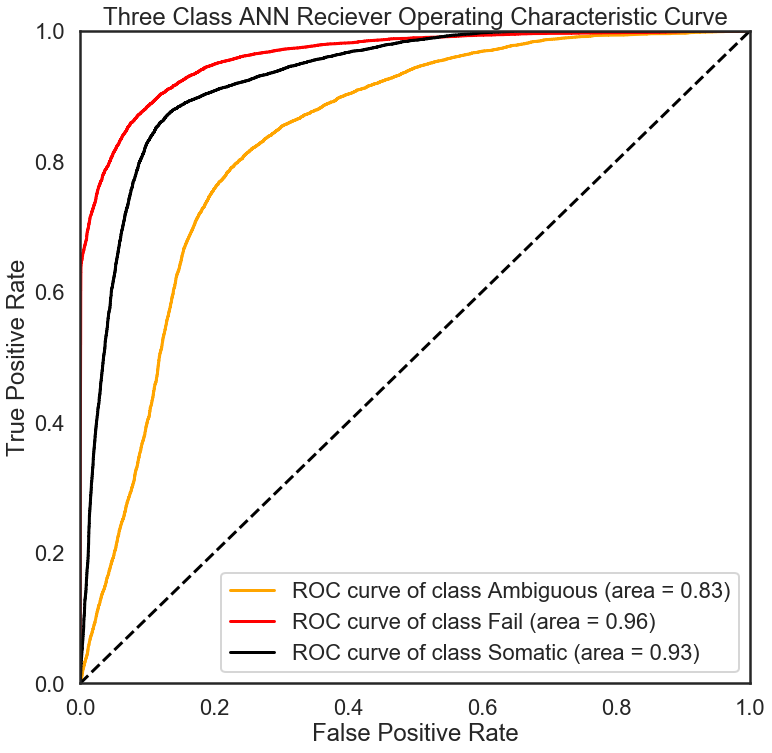

In [70]:
# Plot ROC for the ANN model
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots(figsize=(12,12))
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Three Class ANN Reciever Operating Characteristic Curve', ax)

confidence intervals +-:  [0.00086498 0.00378303 0.00516563 0.00629244 0.00661183 0.006105
 0.00712311 0.0071655  0.00567253 0.00185059]


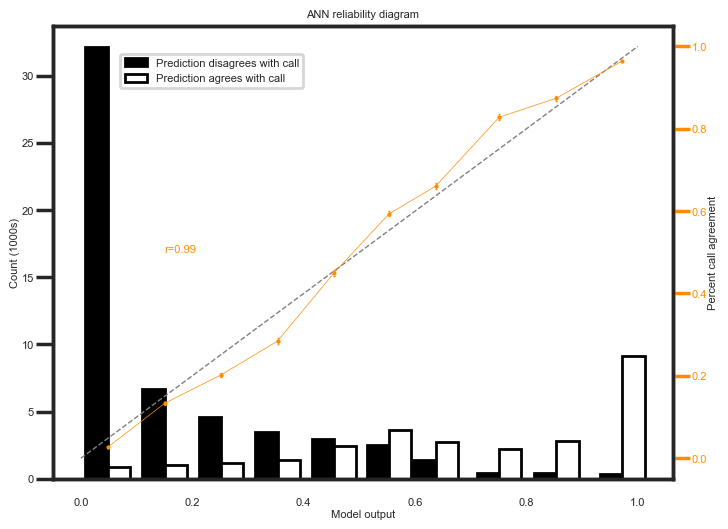

In [34]:
# Plot reliability diagram for ANN
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_one_hot,['Ambiguous','Fail','Somatic'], 'darkorange', 'ANN reliability diagram',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

## Feature importance analysis

In [66]:
# Rebuild the ANN
model = estimator.fit(X_train, Y_train)
# get importance by summing the weights for each feature to the first hidden layer
importance = sum(x for x in model.coefs_[0].T)
importances = list(enumerate(importance))
importances.sort(key=lambda x:x[1], reverse = True)
top_n = importances[:5]
print("The 5 most important features for the ANN are:")
print()
print("feature                     |  summed weights ")
print("-------------------------------------------")
for counter, entry in enumerate(top_n):
    feature = three_class.columns.drop("call")[counter]
    print(feature, " " * (26-len(feature)), "|      {:.9f}".format(entry[1]))

The 5 most important features for the ANN are:

feature                     |  summed weights 
-------------------------------------------
disease_AML                 |      8.405456471
disease_GST                 |      7.191543154
disease_MPNST               |      7.006010032
disease_SCLC                |      4.170167354
disease_breast              |      4.035817951


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  after removing the cwd from sys.path.


### Test set performance

In [67]:
# Determine performance on test set
test_prob = ann.predict_proba(X_test)

In [68]:
# Transform labels for predictions
Y_test_labels = enc.fit_transform(Y_test)

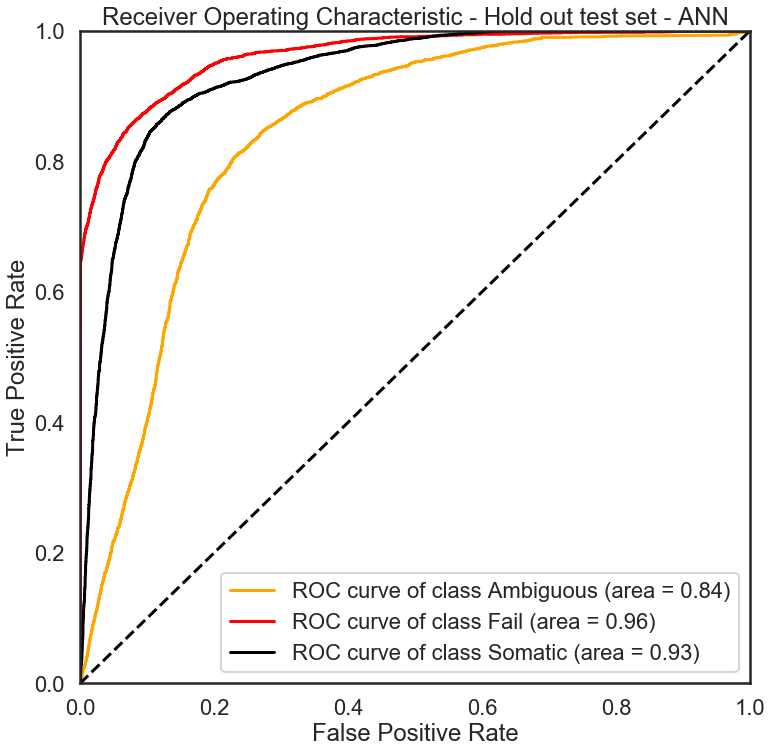

In [72]:
# Plot AUC for test set
fig, ax = plt.subplots(figsize=(12,12))
create_roc_curve(Y_test_labels, test_prob, class_lookup, 'Receiver Operating '
                 'Characteristic - Hold out test set - '
                 'ANN', ax)

confidence intervals +-:  [0.00119268 0.00535264 0.0074606  0.00940752 0.01004324 0.0095167
 0.009337   0.01063962 0.00784476 0.0024548 ]


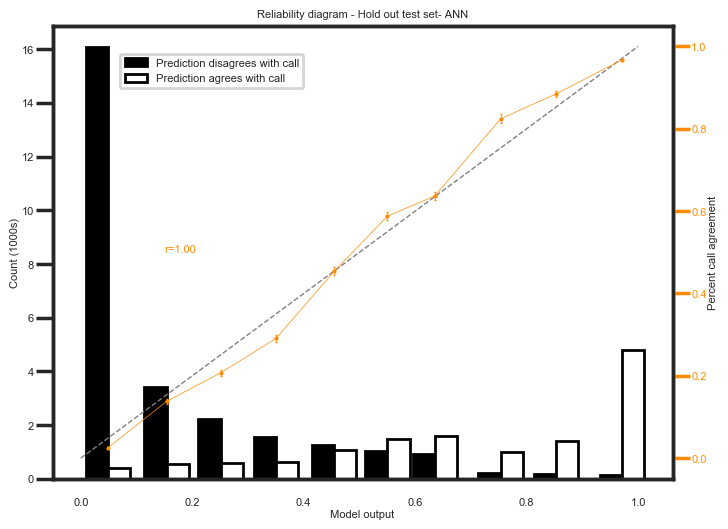

In [73]:
# Plot reliability diagram for test set
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(test_prob, Y_test_labels,
                                 ['Ambiguous','Fail','Somatic'], 
                                 'darkorange', 'Reliability diagram - Hold out test set'
                                 '- ANN',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))